# Задание 1

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.stats as sps
import seaborn as sns
sns.set(style='ticks', font_scale=1.3)

import scipy.optimize
# import torch

rcParams['figure.figsize'] = 10, 5

from typing import Optional, Union, List, Tuple, Any, Callable

In [2]:
import logging

logger = logging.getLogger(__name__)
loglevel = "DEBUG"
logger.setLevel(loglevel)
handler = logging.StreamHandler()
handler.setLevel(loglevel)
format = '%(levelname)s: %(message)s'
handler.setFormatter(logging.Formatter(format))
logger.addHandler(handler)

In [3]:
def draw_convergence_plot(f_vals: np.ndarray, N_iterations: int, label: Optional[str] = None):

    plt.plot(np.arange(N_iterations), f_vals[:N_iterations], lw=3, label=label)

    plt.ylabel("Function value")
    plt.xlabel("Number of iteration")
    if label is not None: plt.legend()
    plt.grid()

# Gradient descent implementation

In [4]:
def gradient_descent(
    n: int, N: int, alpha: float, eps: float, 
    f: Callable, grad_f: Callable,
    params: Tuple[Any, ...] = (),
    x0: Optional[np.ndarray] = None, 
    verbose: bool = False
) -> Tuple[np.ndarray, np.ndarray, int]:
    """ 
    Gradient method
    
    :param n: dimension of x
    :param N: max number of iterations
    :param alpha: initial gradient step
    :param eps: tolerance
    :param f: objective function
    :param grad_f: gradient of objective function
    :param params: objective function arguments
    :param x0: initial guess of x
    :return: f_vals, x_vals, number of iterations
    """
    if verbose:
        logger.setLevel("DEBUG")
    else:
        logger.setLevel("INFO")
    
    if x0 is None:
        x0 = np.random.rand(n)
    
    x = np.zeros((N, n))
    x[0] = x0
    f_vals = np.zeros(N)
    f_vals[0] = f(x[0], *params)
    alphas = np.zeros(N)

    norm_0 = np.linalg.norm(grad_f(x[0], *params))
    end_iteration = N
    
    for k in range(N-1): 
        
        h_k = grad_f(x[k], *params)
        
        # Armijo rule
        while f(x[k] - alpha * h_k, *params) > f(x[k], *params) + 0.2 * alpha * (h_k @ h_k):
            alpha_new = alpha * 0.5
            logger.debug(f"iteration: {k}; Armijo condition is not true, change alpha from {alpha:.6f} to {alpha_new:.6f}")
            alpha = alpha_new
        
        alphas[k] = alpha
        
        # GD step
        x[k+1] = x[k] - alpha * h_k
                
        f_vals[k] = f(x[k], *params)
        f_vals[k+1] = f(x[k+1], *params)
        
        norm_k = np.linalg.norm(grad_f(x[k+1], *params))
        stop_criteria = ((norm_k**2) / (norm_0**2)) <= eps
        
        if stop_criteria:
            end_iteration = k+1
            logger.info(f'GD converge at {k+1} iteration, min f(x) = {f_vals[k+1]}')
            logger.info(f'x_min = {x[k+1]}')
            break

    if not stop_criteria:
        logger.info(f'(!) GD didnt converge, may be need to increase number of iterations N')
        logger.debug(f'last f(x) = {f_vals[k+1]} at x = {x[k+1]}')
        logger.debug(f"current epsilon = {(norm_k**2 / norm_0**2)}")
        
    return f_vals, x, end_iteration

# Rosenbrock function

Функция Розенброка:
$$ f(x_1, x_2) = 100 (x_2 - x_1^2)^2 + (1 - x_1)^2 $$


Найдем аналитически точку минимума:
$$ \frac{\partial f}{\partial x_1} = - 400 x_1 (x_2 - x_1^2) + 2(x_1 - 1)  = 0 \quad \quad (1)
$$
$$ \frac{\partial f}{\partial x_2} = 200 (x_2 - x_1^2) = 0 \quad \quad (2) $$

$$ (2) \Rightarrow (x_2 - x_1^2) = 0 \rightarrow (1) \rightarrow x_1 - 1 = 0$$

$$x_1 = 1 \rightarrow (1) \Rightarrow x_2 = 1$$

**Минимум функции**:
$$ (x_1^*, x_2^*) = (1, 1); \quad f(x_1^*, x_2^*) = 0 $$

In [5]:
def f_Rosenbrock(x: np.ndarray) -> float:
    """Rosenbrock function"""
    x1, x2 = x
    return 100 * (x2 - x1**2)**2 + (1 - x1)**2

def grad_f_Rosenbrock(x: np.ndarray) -> np.ndarray:
    """Gradient of Rosenbrock function f(x1, x2)"""
    x1, x2 = x
    grad_x = -400 * x1 * (x2 - x1**2) + 2 * (x1 - 1)
    grad_y = 200 * (x2 - x1**2)
    
    return np.array([grad_x, grad_y])

## $x_0 = (1.2, 1.2)$

### Gradiend descent

In [6]:
n = 2
N = int(1e6)
alpha = 0.9
eps = 1e-6
x0 = np.array([1.2, 1.2])

f_vals, x, N_iterations = gradient_descent(n, N, alpha, eps, 
                                           f_Rosenbrock, grad_f_Rosenbrock,
                                           x0=x0, verbose=False)

INFO: GD converge at 92 iteration, min f(x) = 0.0028282166602666883
INFO: x_min = [1.05317934 1.10914494]


Text(0.5, 1.0, 'GD')

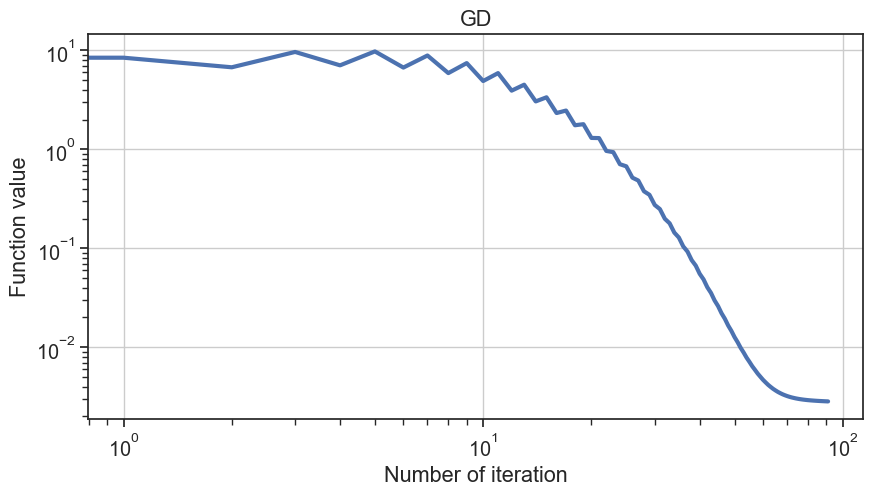

In [7]:
draw_convergence_plot(f_vals, N_iterations)
plt.yscale("log")
plt.xscale("log")
plt.title("GD")

### Adam

In [8]:
import torch

In [9]:
x0 = torch.tensor([[1.2], [1.2]], requires_grad=True)
x = x0

optimizer = torch.optim.Adam([x], lr=0.1)
N_iterations = 1000
f_vals = []

for i in range(N_iterations):
    optimizer.zero_grad()
    f = f_Rosenbrock(x)
    f_vals.append(f.item())
    # print(x, f.item())
    f.backward()
    optimizer.step()

print(f"x_min = {x.detach().numpy().reshape(1, 2)[0]}, f_min = {f[0]}")

x_min = [1.0000272 1.0000546], f_min = 7.648850441910326e-10


Text(0.5, 1.0, 'Adam')

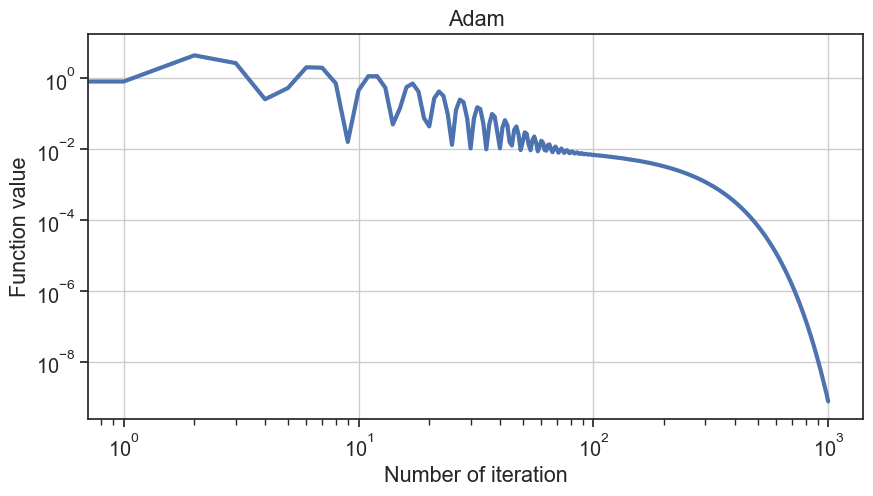

In [10]:
draw_convergence_plot(f_vals, N_iterations)
plt.yscale("log")
plt.xscale("log")
plt.title("Adam")

### RMSProp

In [11]:
x0 = torch.tensor([[1.2], [1.2]], requires_grad=True)
x = x0

optimizer = torch.optim.RMSprop([x], lr=0.01, alpha=0.5)
N_iterations = 10000
f_vals = []

for i in range(N_iterations):
    optimizer.zero_grad()
    f = f_Rosenbrock(x)
    f_vals.append(f.item())
    # print(x, f.item())
    f.backward()
    optimizer.step()
    
print(f"x_min = {x.detach().numpy().reshape(1, 2)[0]}, f_min = {f[0]}")

x_min = [0.98023707 0.97571737], f_min = 0.022153643891215324


Text(0.5, 1.0, 'RMSprop')

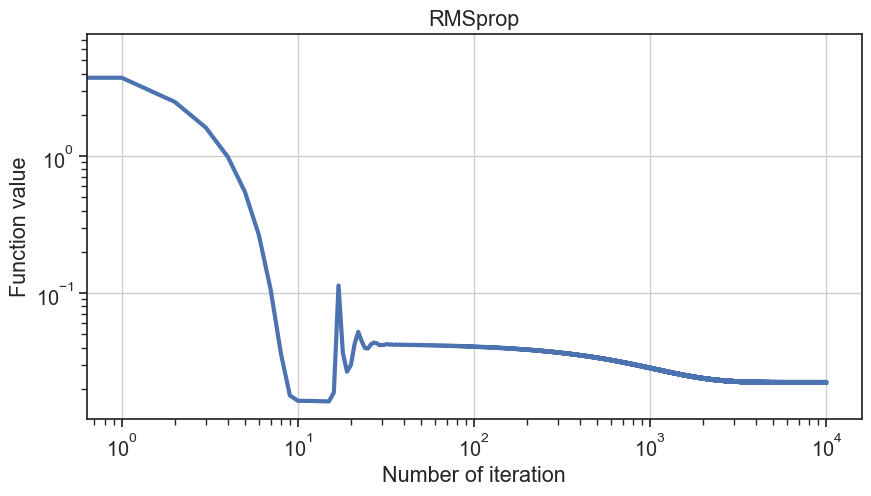

In [12]:
draw_convergence_plot(f_vals, N_iterations)
plt.yscale("log")
plt.xscale("log")
plt.title("RMSprop")

### Conjugate gradients

In [13]:
x0 = np.array([1.2, 1.2])
f_vals = [ f_Rosenbrock(x0) ]

def history(x):
    global f_vals
    f_vals.append(f_Rosenbrock(x))

res = scipy.optimize.minimize(f_Rosenbrock, x0=x0, jac=grad_f_Rosenbrock, method='CG', callback=history)
N_iterations = res["nit"]
res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 2.954858224270024e-11
       x: [ 1.000e+00  1.000e+00]
     nit: 12
     jac: [ 1.740e-06  4.561e-06]
    nfev: 31
    njev: 30

Text(0.5, 1.0, 'Conjugate gradients')

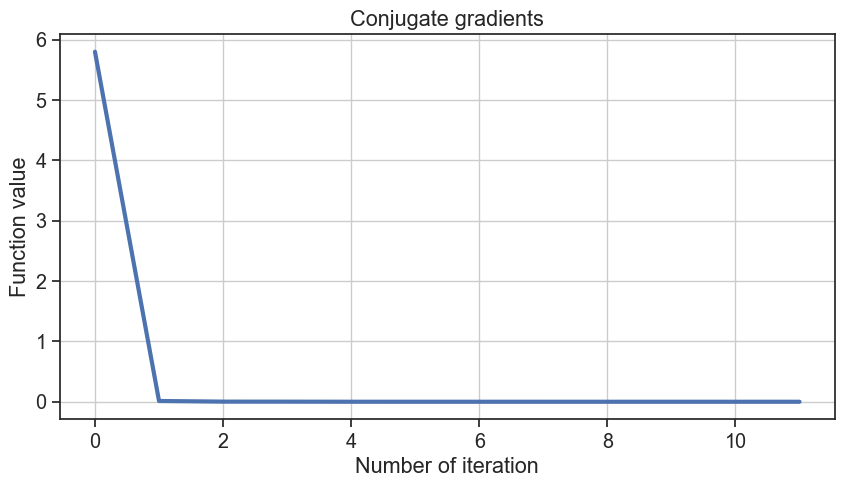

In [14]:
draw_convergence_plot(f_vals, N_iterations)
plt.title("Conjugate gradients")

## $x_0 = (-10, -7)$

### Gradiend descent

In [15]:
n = 2
N = int(1e6)
alpha = 0.001
eps = 1e-15
x0 = np.array([-10., -7.])

f_vals, x, N_iterations = gradient_descent(n, N, alpha, eps, 
                                           f_Rosenbrock, grad_f_Rosenbrock,
                                           x0=x0, verbose=False)

INFO: GD converge at 242973 iteration, min f(x) = 0.00022448217168155463
INFO: x_min = [0.98502947 0.97022261]


Text(0.5, 1.0, 'GD')

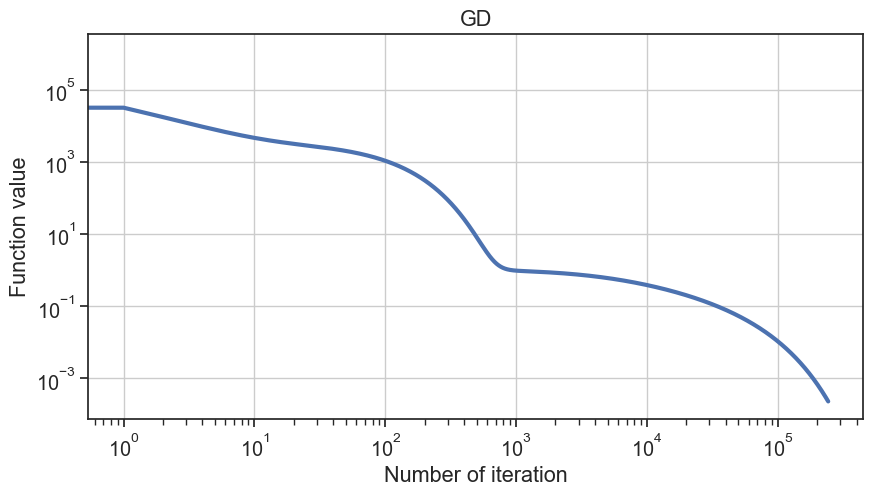

In [16]:
draw_convergence_plot(f_vals, N_iterations)
plt.yscale("log")
plt.xscale("log")
plt.title("GD")

Вывод:

При таком начальном приближении требуется гораздо больше итераций для сходимости метода

### Adam

In [17]:
import torch

In [18]:
x0 = torch.tensor([[-10.], [-7.]], requires_grad=True)
x = x0

optimizer = torch.optim.Adam([x], lr=0.01)
N_iterations = 100000
f_vals = []

for i in range(N_iterations):
    optimizer.zero_grad()
    f = f_Rosenbrock(x)
    f_vals.append(f.item())
    # print(x, f.item())
    f.backward()
    optimizer.step()

print(f"x_min = {x.detach().numpy().reshape(1, 2)[0]}, f_min = {f[0]}")

x_min = [1.0000026 0.9999933], f_min = 1.1028774338228686e-08


Text(0.5, 1.0, 'Adam')

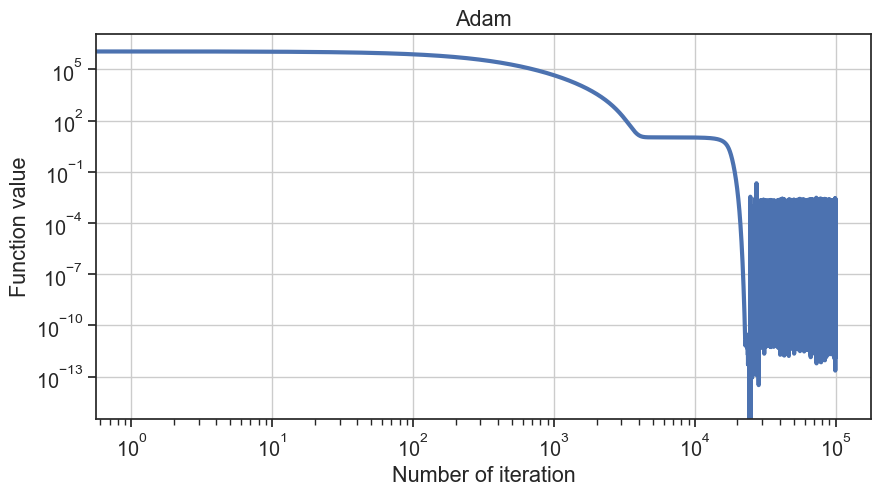

In [19]:
draw_convergence_plot(f_vals, N_iterations)
plt.yscale("log")
plt.xscale("log")
plt.title("Adam")

### RMSProp

In [20]:
x0 = torch.tensor([[-10.], [-7.]], requires_grad=True)
x = x0

optimizer = torch.optim.RMSprop([x], lr=0.01, alpha=0.5)
N_iterations = 50000
f_vals = []

for i in range(N_iterations):
    optimizer.zero_grad()
    f = f_Rosenbrock(x)
    f_vals.append(f.item())
    # print(x, f.item())
    f.backward()
    optimizer.step()
    
print(f"x_min = {x.detach().numpy().reshape(1, 2)[0]}, f_min = {f[0]}")

x_min = [0.9901352 0.9655163], f_min = 0.02245081588625908


Text(0.5, 1.0, 'RMSprop')

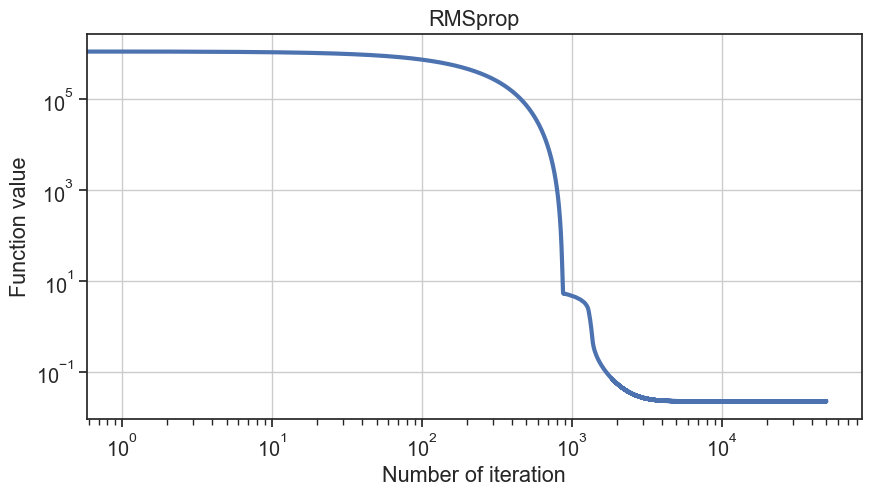

In [21]:
draw_convergence_plot(f_vals, N_iterations)
plt.yscale("log")
plt.xscale("log")
plt.title("RMSprop")

### Conjugate gradients

In [22]:
x0 = np.array([-10., -7.])
f_vals = [ f_Rosenbrock(x0) ]

def history(x):
    global f_vals
    f_vals.append(f_Rosenbrock(x))

res = scipy.optimize.minimize(f_Rosenbrock, x0=x0, jac=grad_f_Rosenbrock, method='CG', callback=history)
N_iterations = res["nit"]
res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 2.949955296156915e-13
       x: [ 1.000e+00  1.000e+00]
     nit: 36
     jac: [ 6.609e-06 -3.813e-06]
    nfev: 86
    njev: 84

Text(0.5, 1.0, 'Conjugate gradients')

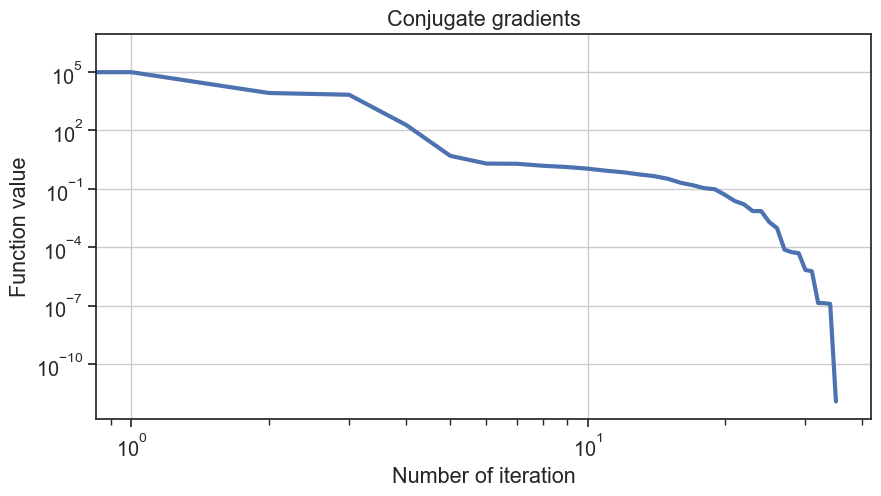

In [23]:
draw_convergence_plot(f_vals, N_iterations)
plt.yscale("log")
plt.xscale("log")
plt.title("Conjugate gradients")

# Himmelblau's function

Функция:
$$ f(x_1, x_2) = (x_1^2 + x_2 - 11)^2 + (x_1 + x_2^2 - 7)^2 $$


Частные производные:

$$ \frac{\partial f}{\partial x_1} = 4x_1 (x_1^2 + x_2 - 11) + 2 (x_1 + x_2^2 - 7) $$

$$ \frac{\partial f}{\partial x_2} = 2 (x_1^2 + x_2 - 11) + 4x_2 (x_1 + x_2^2 - 7)  $$

Минимум функции:
$$ {\displaystyle {\text{min} ~ f(x_1, x_2)}={\begin{cases}f\left(3.0,2.0\right)&=0.0\\f\left(-2.805118,3.131312\right)&=0.0\\f\left(-3.779310,-3.283186\right)&=0.0\\f\left(3.584428,-1.848126\right)&=0.0\\\end{cases}}} $$

In [24]:
def f_Himmelblau(x: np.ndarray) -> float:
    x1, x2 = x
    return (x1**2 + x2 - 11)**2 + (x1 + x2**2 - 7)**2

def grad_f_Himmelblau(x: np.ndarray) -> np.ndarray:
    x1, x2 = x
    df_dx1 = 4*x1 * (x1**2 + x2 - 11) + 2 * (x1 + x2**2 - 7)
    df_dx2 = 2 * (x1**2 + x2 - 11) + 4*x2 * (x1 + x2**2 - 7)
    return np.array([df_dx1, df_dx2])

## $x_0 = (1.2, 1.2)$

### Gradiend descent

In [25]:
n = 2
N = int(1e6)
alpha = 0.9
eps = 1e-6
x0 = np.array([1.2, 1.2])

f_vals, x, N_iterations = gradient_descent(n, N, alpha, eps, 
                                           f_Himmelblau, grad_f_Himmelblau,
                                           x0=x0, verbose=False)

INFO: GD converge at 55 iteration, min f(x) = 1.2751976365584382e-05
INFO: x_min = [-3.77893914 -3.28341603]


Text(0.5, 1.0, 'GD')

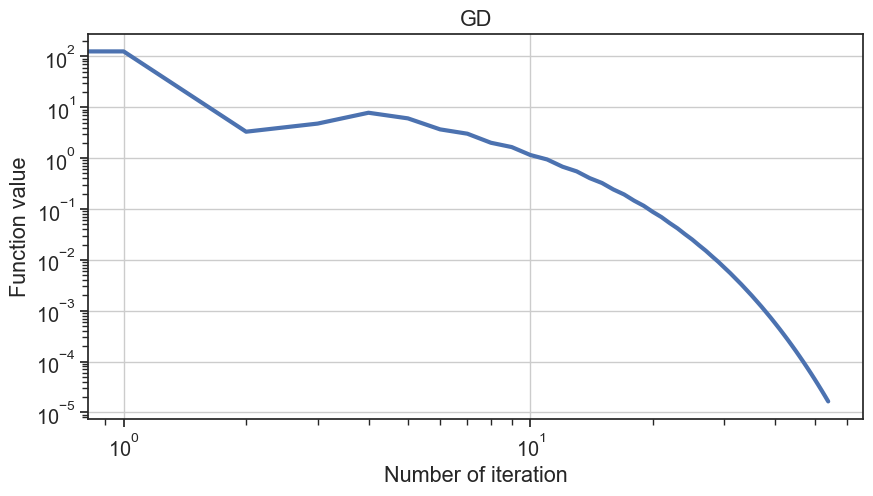

In [26]:
draw_convergence_plot(f_vals, N_iterations)
plt.yscale("log")
plt.xscale("log")
plt.title("GD")

### Adam

In [27]:
x0 = torch.tensor([[1.2], [1.2]], requires_grad=True)
x = x0

optimizer = torch.optim.Adam([x], lr=0.1)
N_iterations = 1000
f_vals = []

for i in range(N_iterations):
    optimizer.zero_grad()
    f = f_Himmelblau(x)
    f_vals.append(f.item())
    # print(x, f.item())
    f.backward()
    optimizer.step()

print(f"x_min = {x.detach().numpy().reshape(1, 2)[0]}, f_min = {f[0]}")

x_min = [3. 2.], f_min = 0.0


Text(0.5, 1.0, 'Adam')

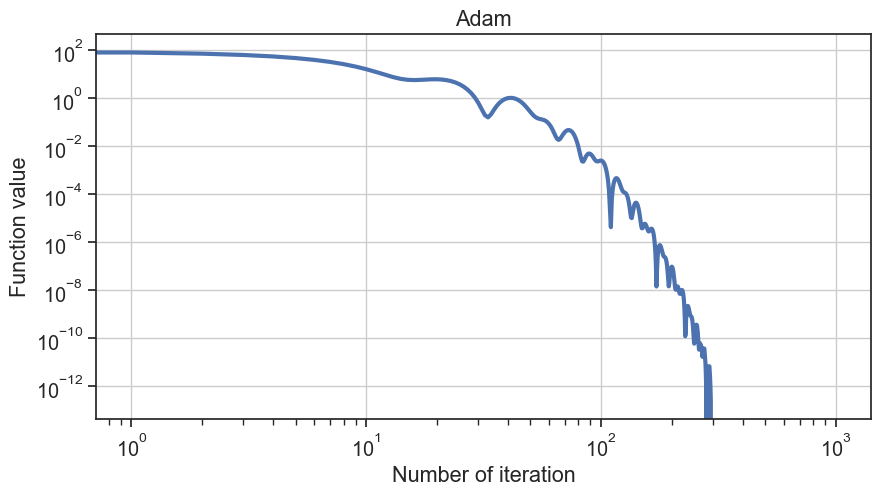

In [28]:
draw_convergence_plot(f_vals, N_iterations)
plt.yscale("log")
plt.xscale("log")
plt.title("Adam")

### RMSProp

In [29]:
x0 = torch.tensor([[1.2], [1.2]], requires_grad=True)
x = x0

optimizer = torch.optim.RMSprop([x], lr=0.01, alpha=0.5)
N_iterations = 10000
f_vals = []

for i in range(N_iterations):
    optimizer.zero_grad()
    f = f_Himmelblau(x)
    f_vals.append(f.item())
    # print(x, f.item())
    f.backward()
    optimizer.step()
    
print(f"x_min = {x.detach().numpy().reshape(1, 2)[0]}, f_min = {f[0]}")

x_min = [3.00499   2.0049837], f_min = 0.0018560406751930714


Text(0.5, 1.0, 'RMSprop')

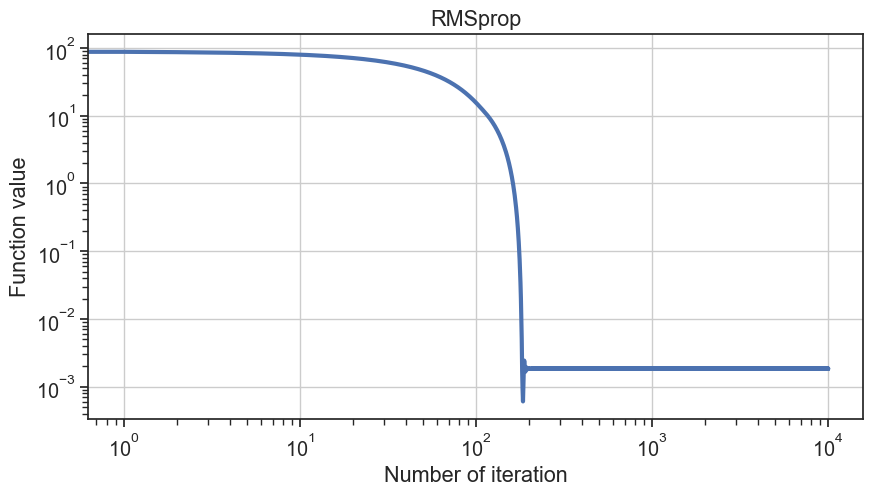

In [30]:
draw_convergence_plot(f_vals, N_iterations)
plt.yscale("log")
plt.xscale("log")
plt.title("RMSprop")

### Conjugate gradients

In [31]:
x0 = np.array([1.2, 1.2])
f_vals = [ f_Himmelblau(x0) ]

def history(x):
    global f_vals
    f_vals.append(f_Himmelblau(x))

res = scipy.optimize.minimize(f_Himmelblau, x0=x0, jac=grad_f_Himmelblau, method='CG', callback=history)
N_iterations = res["nit"]
res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1.5200068386676106e-16
       x: [ 3.000e+00  2.000e+00]
     nit: 8
     jac: [ 1.151e-07  9.090e-08]
    nfev: 19
    njev: 19

Text(0.5, 1.0, 'Conjugate gradients')

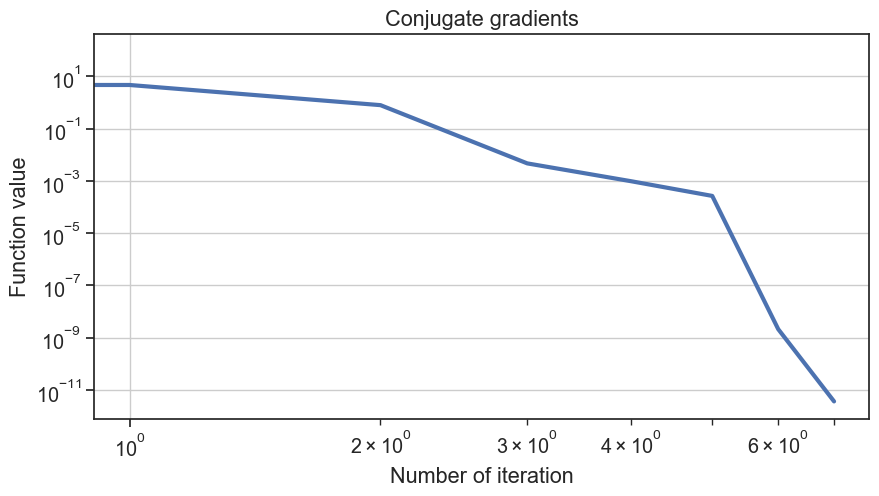

In [32]:
draw_convergence_plot(f_vals, N_iterations)
plt.yscale("log")
plt.xscale("log")
plt.title("Conjugate gradients")

## $x_0 = (-3, -5)$

### Gradiend descent

In [33]:
n = 2
N = int(1e6)
alpha = 0.5
eps = 1e-5
x0 = np.array([-3., -5.])

f_vals, x, N_iterations = gradient_descent(n, N, alpha, eps, 
                                           f_Himmelblau, grad_f_Himmelblau,
                                           x0=x0, verbose=False)

INFO: GD converge at 14 iteration, min f(x) = 0.0017558543520574267
INFO: x_min = [-3.78482665 -3.28328974]


Text(0.5, 1.0, 'GD')

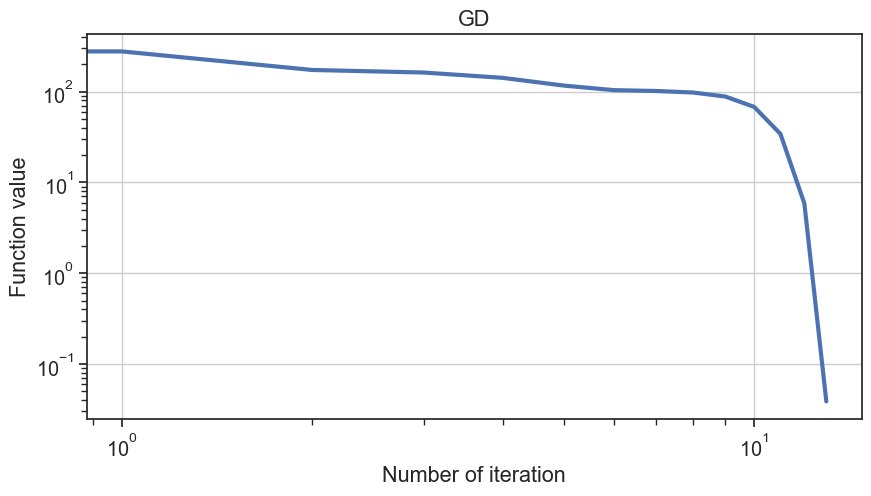

In [34]:
draw_convergence_plot(f_vals, N_iterations)
plt.yscale("log")
plt.xscale("log")
plt.title("GD")

### Adam

In [35]:
x0 = torch.tensor([[-3.], [-5.]], requires_grad=True)
x = x0

optimizer = torch.optim.Adam([x], lr=0.1)
N_iterations = 1000
f_vals = []

for i in range(N_iterations):
    optimizer.zero_grad()
    f = f_Himmelblau(x)
    f_vals.append(f.item())
    # print(x, f.item())
    f.backward()
    optimizer.step()

print(f"x_min = {x.detach().numpy().reshape(1, 2)[0]}, f_min = {f[0]}")

x_min = [-3.7793102 -3.2831862], f_min = 9.094947017729282e-13


Text(0.5, 1.0, 'Adam')

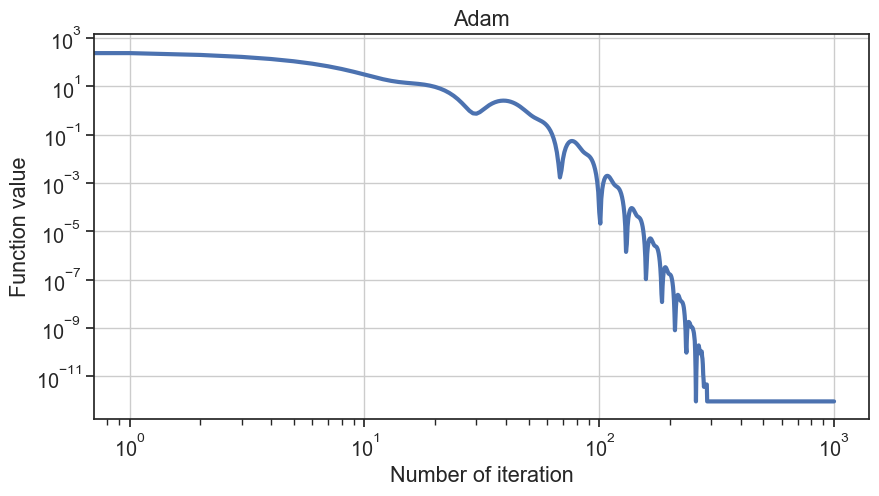

In [36]:
draw_convergence_plot(f_vals, N_iterations)
plt.yscale("log")
plt.xscale("log")
plt.title("Adam")

### RMSProp

In [37]:
x0 = torch.tensor([[-3.], [-5]], requires_grad=True)
x = x0

optimizer = torch.optim.RMSprop([x], lr=0.01, alpha=0.5)
N_iterations = 10000
f_vals = []

for i in range(N_iterations):
    optimizer.zero_grad()
    f = f_Himmelblau(x)
    f_vals.append(f.item())
    # print(x, f.item())
    f.backward()
    optimizer.step()
    
print(f"x_min = {x.detach().numpy().reshape(1, 2)[0]}, f_min = {f[0]}")

x_min = [-3.7842963 -3.2781696], f_min = 0.003263133578002453


Text(0.5, 1.0, 'RMSprop')

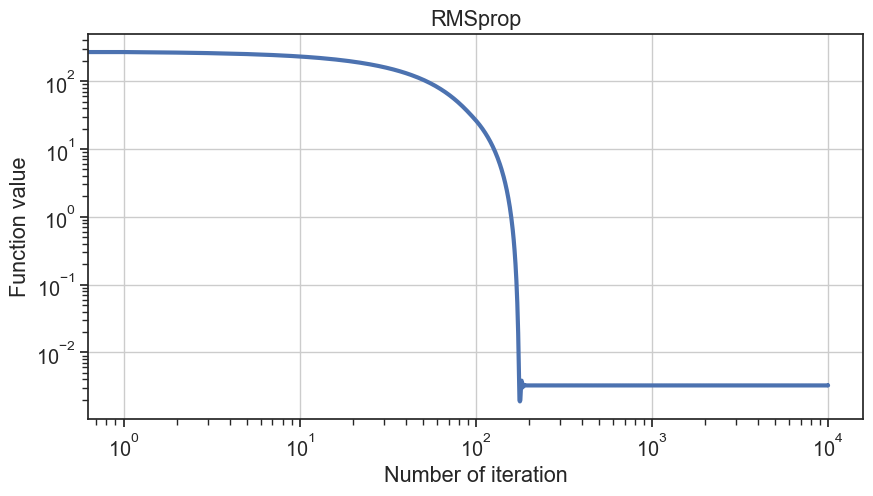

In [38]:
draw_convergence_plot(f_vals, N_iterations)
plt.yscale("log")
plt.xscale("log")
plt.title("RMSprop")

### Conjugate gradients

In [39]:
x0 = np.array([-3., -5.])
f_vals = [ f_Himmelblau(x0) ]

def history(x):
    global f_vals
    f_vals.append(f_Himmelblau(x))

res = scipy.optimize.minimize(f_Himmelblau, x0=x0, jac=grad_f_Himmelblau, method='CG', callback=history)
N_iterations = res["nit"]
res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 3.0024493965354056e-14
       x: [-3.779e+00 -3.283e+00]
     nit: 8
     jac: [ 6.735e-07  1.974e-06]
    nfev: 16
    njev: 16

Text(0.5, 1.0, 'Conjugate gradients')

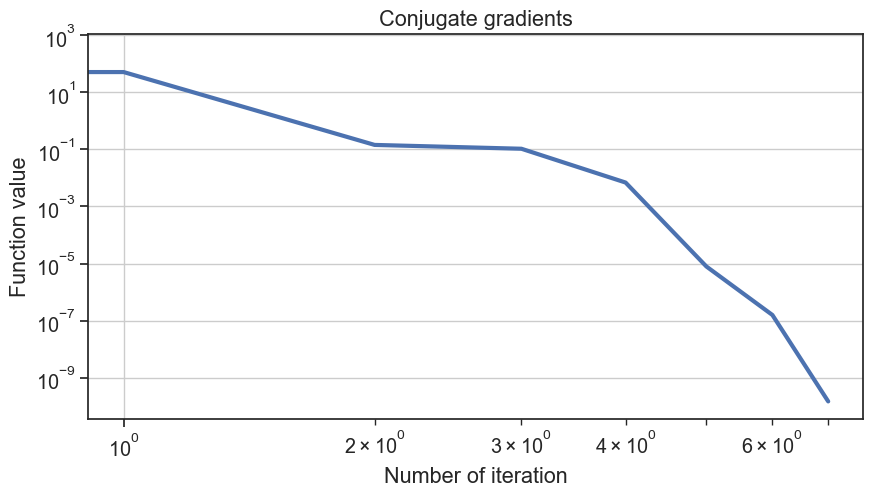

In [40]:
draw_convergence_plot(f_vals, N_iterations)
plt.yscale("log")
plt.xscale("log")
plt.title("Conjugate gradients")

Вывод:

Тк у функции несколько минимумов, результат минимизации сильно зависит от начального приближения